In [0]:
#https://github.com/tbayetird/freesound-audio-tagging-2019

In [2]:
!ls

sample_data


In [3]:
!pip install kaggle

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [0]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions list

ref                                                deadline             category            reward  teamCount  userHasEntered  
-------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                   2030-01-01 00:00:00  Getting Started  Knowledge       3019            True  
titanic                                            2030-01-01 00:00:00  Getting Started  Knowledge      11352            True  
house-prices-advanced-regression-techniques        2030-01-01 00:00:00  Getting Started  Knowledge       4585           False  
imagenet-object-localization-challenge             2029-12-31 07:00:00  Research         Knowledge         37           False  
competitive-data-science-predict-future-sales      2019-12-31 23:59:00  Playground           Kudos       3118            True  
two-sigma-financial-news                           2019-07-15 23:59:00  Featured          $100,000      

In [10]:
!kaggle competitions download -c freesound-audio-tagging-2019

100% 20.0G/20.0G [02:28<00:00, 109MB/s] 
100% 20.0G/20.0G [02:28<00:00, 144MB/s]
  0% 0.00/571k [00:00<?, ?B/s]
100% 571k/571k [00:00<00:00, 78.5MB/s]
100% 2.23G/2.24G [00:15<00:00, 120MB/s]
100% 2.24G/2.24G [00:15<00:00, 155MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 123MB/s]
  0% 0.00/190k [00:00<?, ?B/s]
100% 190k/190k [00:00<00:00, 168MB/s]
 97% 649M/666M [00:04<00:00, 141MB/s]
100% 666M/666M [00:04<00:00, 158MB/s]


In [11]:
!ls

sample_data	       test.zip		  train_curated.zip  train_noisy.zip
sample_submission.csv  train_curated.csv  train_noisy.csv


In [0]:
# Change this to True for full dataset and learning
COMPLETE_RUN = False

import numpy as np
np.random.seed(1001)

import os
import shutil
import warnings

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

# %matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning)

 ### 1. Exploratory Data Analysis

## Loading datas

In [13]:
datadir = '/content'
os.listdir(datadir)
train = pd.read_csv(os.path.join(datadir,"train_curated.csv"))
test = pd.read_csv(os.path.join(datadir,"sample_submission.csv"))
# train.sample(10)
# test.sample(5)



print("Number of train examples=", train.shape[0], "  Number of classes=", len(set(train.labels)))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train examples= 4970   Number of classes= 213
Number of test examples= 1120   Number of classes= 80


##Distribution of Categories

In [14]:
train = train[train.labels.isin(test.columns[1:])]
print(len(train))

category_group = train.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

4269
74


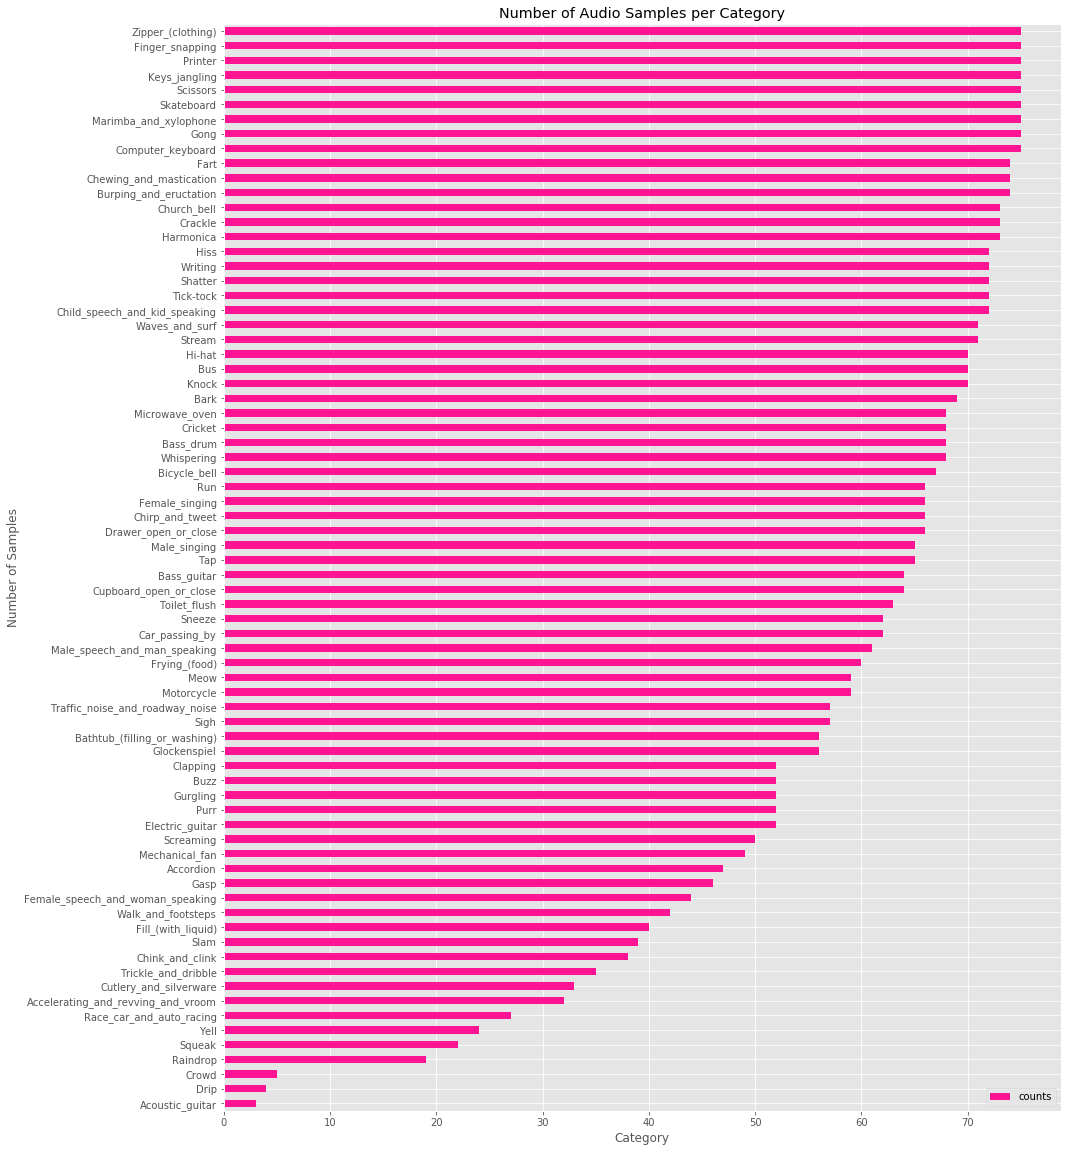

In [15]:
plot = category_group.sort_values(ascending=True, by='counts').plot(
    kind='barh',
    title="Number of Audio Samples per Category",
    color='deeppink',
    figsize=(15,20))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [16]:
print('Minimum samples per category = ', min(train.labels.value_counts()))
print('Maximum samples per category = ', max(train.labels.value_counts()))

Minimum samples per category =  3
Maximum samples per category =  75


##Reading audio files

In [0]:
!mkdir train_curated
!mkdir train_noisy
!mkdir test

In [23]:
!unzip test.zip -d test

Archive:  test.zip
  inflating: test/3d9a715d.wav       
  inflating: test/0c32d940.wav       
  inflating: test/03fe2971.wav       
  inflating: test/13728313.wav       
  inflating: test/36027dca.wav       
  inflating: test/1a110901.wav       
  inflating: test/0fffc208.wav       
  inflating: test/2451cad9.wav       
  inflating: test/3c216393.wav       
  inflating: test/40d0726d.wav       
  inflating: test/0c3b2573.wav       
  inflating: test/361237d6.wav       
  inflating: test/25e75fa8.wav       
  inflating: test/12ddf239.wav       
  inflating: test/1175ac74.wav       
  inflating: test/0fc6a683.wav       
  inflating: test/0ce84f9b.wav       
  inflating: test/0064aedf.wav       
  inflating: test/3012731a.wav       
  inflating: test/272d95c7.wav       
  inflating: test/309169fa.wav       
  inflating: test/2113043a.wav       
  inflating: test/30e40cc3.wav       
  inflating: test/15c34c4f.wav       
  inflating: test/2cfdaecd.wav       
  inflating: test/039d2821.wav 

In [24]:
!unzip train_noisy.zip -d train_noisy

Archive:  train_noisy.zip
  inflating: train_noisy/6dd81c5a.wav  
  inflating: train_noisy/8673f1a1.wav  
  inflating: train_noisy/0eb824eb.wav  
  inflating: train_noisy/f97e8551.wav  
  inflating: train_noisy/84ca96ab.wav  
  inflating: train_noisy/5f909074.wav  
  inflating: train_noisy/5e71e8b1.wav  
  inflating: train_noisy/76ccf020.wav  
  inflating: train_noisy/1f674089.wav  
  inflating: train_noisy/9740dda6.wav  
  inflating: train_noisy/5094db8a.wav  
  inflating: train_noisy/27b09d82.wav  
  inflating: train_noisy/5cebe76a.wav  
  inflating: train_noisy/c625c68a.wav  
  inflating: train_noisy/91a3fb1c.wav  
  inflating: train_noisy/8c712129.wav  
  inflating: train_noisy/537e5a92.wav  
  inflating: train_noisy/f8006010.wav  
  inflating: train_noisy/9a1f4d48.wav  
  inflating: train_noisy/b510e20b.wav  
  inflating: train_noisy/110f7af6.wav  
  inflating: train_noisy/edcf2409.wav  
  inflating: train_noisy/30129f45.wav  
  inflating: train_noisy/2c625ed4.wav  
  inflating: t

In [25]:
!unzip train_curated.zip -d train_curated

Archive:  train_curated.zip
  inflating: train_curated/c1b84d6f.wav  
  inflating: train_curated/37acc887.wav  
  inflating: train_curated/8d1fb22b.wav  
  inflating: train_curated/fd621ec3.wav  
  inflating: train_curated/b2196421.wav  
  inflating: train_curated/5ea6937f.wav  
  inflating: train_curated/03ea2668.wav  
  inflating: train_curated/d3184ca4.wav  
  inflating: train_curated/775a890a.wav  
  inflating: train_curated/a25aedbc.wav  
  inflating: train_curated/50242b6c.wav  
  inflating: train_curated/59099afd.wav  
  inflating: train_curated/08f26926.wav  
  inflating: train_curated/3ede79fd.wav  
  inflating: train_curated/23ee33f6.wav  
  inflating: train_curated/7419fde6.wav  
  inflating: train_curated/84e4fa67.wav  
  inflating: train_curated/cbc963cb.wav  
  inflating: train_curated/950b1afa.wav  
  inflating: train_curated/9950cecb.wav  
  inflating: train_curated/92601183.wav  
  inflating: train_curated/8ebf9f33.wav  
  inflating: train_curated/824d9810.wav  
  infl

In [26]:
import IPython.display as ipd  # To play sound in the notebook
fname = os.path.join(datadir,'train_curated/0019ef41.wav')   # Raindrop
ipd.Audio(fname)

In [27]:
# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  90616
Duration =  2.054784580498866


In [28]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (90616,)
[ 369 -577  -49 ...    0    0    0]


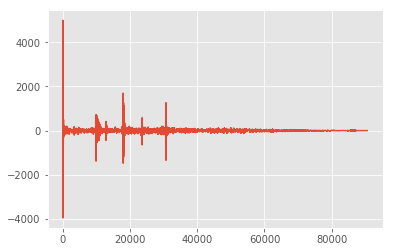

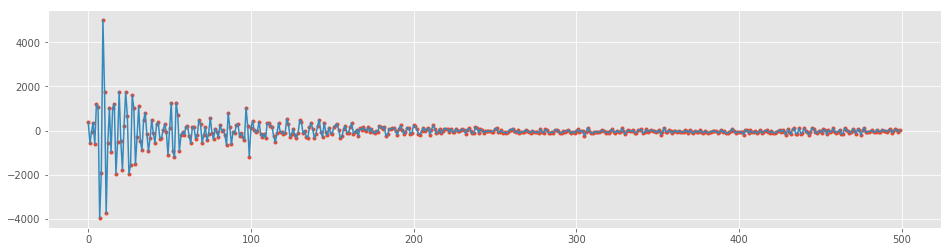

In [30]:
plt.plot(data, '-', );
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');
plt.show()
##Audio length
train['nframes'] = train['fname'].apply(lambda f: wave.open(os.path.join(datadir,'train_curated',f)).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open(os.path.join(datadir,'test',f)).getnframes())
# train.head()

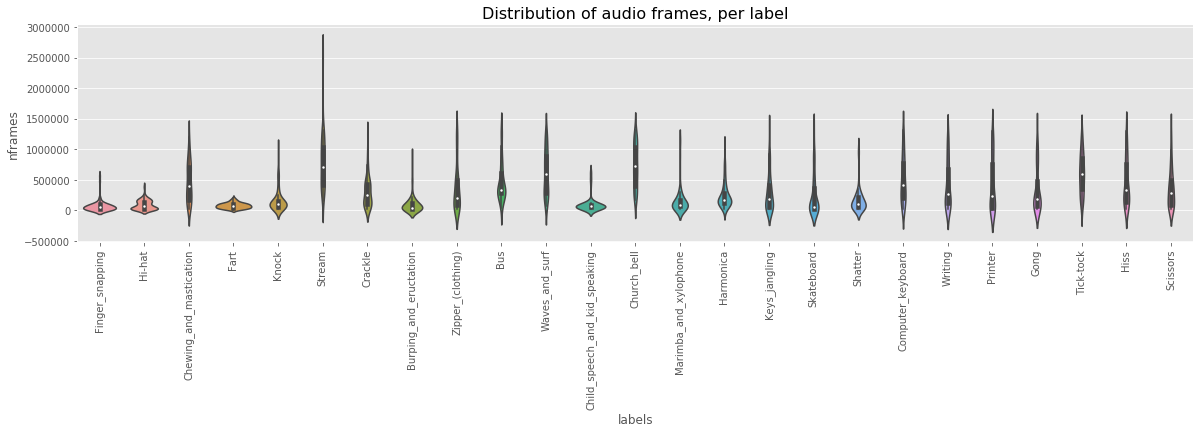

In [31]:
idx_sel = category_group.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train[(train.labels.isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

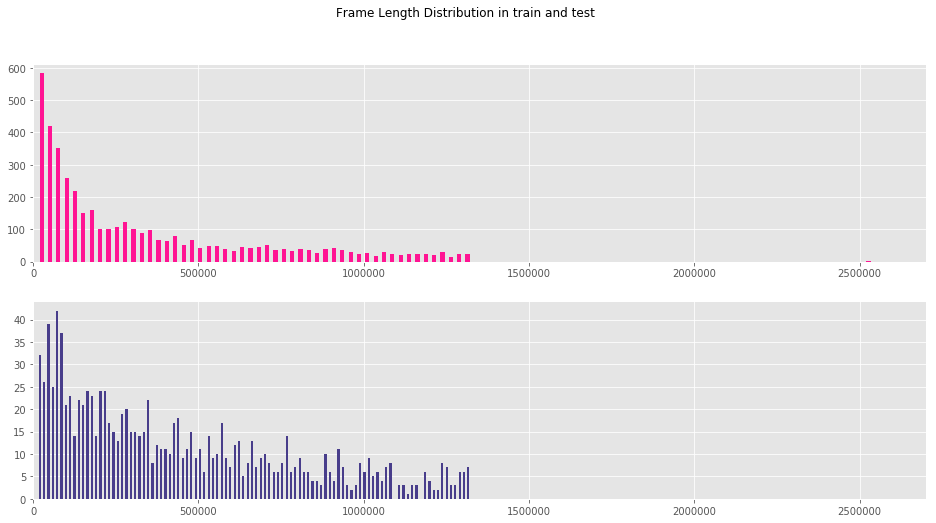

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
train.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='deeppink')
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');
plt.show()

In [0]:
train_curated = os.path.join(datadir,'train_curated')
train.query("nframes > 2500000")
abnormal_length = 2538889
abnormal_fnames = train.loc[train.nframes == abnormal_length, 'fname'].values[0]
# ipd.Audio( train_curated +'\\' + abnormal_fnames)

### 2. Building a model using raw wave

In [34]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D,
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [0]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2,
                 n_classes=len(category_group),
                 use_mfcc=False, n_folds=10, learning_rate=0.0001,
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [0]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None,
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir +'/'+ ID

            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [0]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data - 0.5

def get_1d_dummy_model(config):

    nclass = config.n_classes
    input_length = config.audio_length

    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):

    nclass = config.n_classes
    input_length = config.audio_length

    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)

    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [0]:
LABELS = list(train.labels.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.labels.apply(lambda x: label_idx[x])

# if not COMPLETE_RUN:
#     train = train[:2000]
#     test = test[:2000]
train = train[:2000]
test = test[:2000]

In [0]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=4, learning_rate=0.001)
# if not COMPLETE_RUN:
#     config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

#config = Config(sampling_rate=100, audio_duration=2, n_folds=10, max_epochs=10)

config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

In [0]:
!mkdir output

In [0]:
PREDICTION_FOLDER = os.path.join(datadir,"predictions_1d_conv")
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
logsdir = os.path.join(datadir,'logs')
if os.path.exists(logsdir):
    shutil.rmtree(logsdir)

In [0]:
skf = StratifiedKFold(n_splits=config.n_folds)

In [48]:
for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint(os.path.join(datadir,'best_%d.h5'%i), monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    # tb = TensorBoard(log_dir=logsdir + '\\fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early]
    print("\nFold: ", i)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)
    model.summary()

    train_generator = DataGenerator(config, train_curated, train_set.index,
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, train_curated, val_set.index,
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)

    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, max_queue_size=20)

# Save train predictions
    train_generator = DataGenerator(config, train_curated, train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator,
                                          max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    test_generator = DataGenerator(config, os.path.join(datadir,'test'), test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator,
                                          max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)


Fold:  0
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 74)                148       
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Epoch 1/1
16/16 [==============================] - 118s 7s/step - loss: 4.3053 - acc: 0.0186 - val_loss: 4.3045 - val_acc: 0.0196

Epoch 00001: val_loss improved from inf to 4.30452, saving model to /content/best_0.h5
9/9 [==============================] - 126s 14s/step

Fold:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 74)                148       
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
16/16 [==============================] - 117s 7s/step - loss: 4.3046 - acc: 0.0156 - val_loss: 4.3047 - val_acc: 0.01

In [0]:
pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load(datadir +"/predictions_1d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv(datadir +'/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv(datadir + "/output/1d_conv_ensembled_submission.csv", index=False)